# Telco Churn

**Why are Customers Leaving Telco?**

by Corey Baughman

___

## Imports

In [1]:
import numpy as np
import seaborn as sns
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from math import sqrt
# to turn off pink warning boxes basically for display purposes in class
import warnings
warnings.filterwarnings('ignore')

# import splitting and imputing functions
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# classification algorithms
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# classification analysis
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# to see local file system
import os

# import our own modules
import env
import acquire as a
import prepare as p

# jupyter settings
%matplotlib inline

___

## Acquire

* Data on customer churn was made available from Telco's mySQL database.
* Data was received March 16th, 2023.
* The data appears to be for the month of January 2022 only.
* The original import was 47 columns and 7,043 rows.
* Each observation (row) represents one customer's data?
* Each column represents an item of data collected for all customers.
* The dataset is wide, so I will display it transposed below.

In [2]:
td = a.get_telco_data()
td.head().T

,0,1,2,3,4
customer_id,0002-ORFBO,0003-MKNFE,0004-TLHLJ,0011-IGKFF,0013-EXCHZ
gender,Female,Male,Male,Male,Female
senior_citizen,0,0,0,1,1
partner,Yes,No,No,Yes,Yes
dependents,Yes,No,No,No,No
tenure,9,9,4,13,3
phone_service,Yes,Yes,Yes,Yes,Yes
multiple_lines,No,Yes,No,No,No
internet_service_type_id,1,1,2,2,2
online_security,No,No,No,No,No


___

## Prepare

#### Data Cleaning Steps:
    1. Dropped duplicate columns from joining tables in SQL.
    2. Dropped 'contract_type_id', internet_service_type_id, and payment_type_id as they were redundant.
    3. Dropped 'signup_date' as 'tenure' captured most of that feature.
    4. Dropped customer_id field as rows were now identified by index.
    5. Dropped 'churn_month' as all values were 1-31-2022. There was only one month's data.
    6. 'total_charges' imported as an object instead of a float due to empty values for new customers whose charges apparently had not been aggregated yet. Added '0' to all values in this feature and then cast to float.
    7. Null values were only encountered in 'total_values' and were addressed as noted in 5.
    8. There were no significant outliers to address.
    9. I did not encode values until after univariate exploration.

Below is the code for the function used in initial cleaning:

In [4]:
# def telco_pre_split_clean(df):
    # '''
    # function takes in the Telco DataFrame from the acquire 
    # module's get_telco_data function and applies steps to 
    # drop duplicate and unnecessary columns as well a casting 
    # the total_charges feature from object to float values.
    # '''
    # dup_cols = [col for col in df.columns if col.endswith(('1', '2'))]
    # df.drop(columns=dup_cols, inplace=True)
    # df.drop(columns=['contract_type_id', 'internet_service_type_id',
    #              'payment_type_id'], inplace=True)
    # df.drop(columns='signup_date', inplace=True)
    # df.drop(columns='churn_month', inplace=True)
    # df.total_charges = (df.total_charges + '0').astype('float')
    # return df

In [5]:
from prepare import telco_pre_split_clean

td = telco_pre_split_clean(td)
td.head()


,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,internet_service_type,contract_type,payment_type
0,0002-ORFBO,Female,0,Yes,Yes,9,Yes,No,No,Yes,...,Yes,Yes,No,Yes,65.6,593.30,No,DSL,One year,Mailed check
1,0003-MKNFE,Male,0,No,No,9,Yes,Yes,No,No,...,No,No,Yes,No,59.9,542.40,No,DSL,Month-to-month,Mailed check
2,0004-TLHLJ,Male,0,No,No,4,Yes,No,No,No,...,No,No,No,Yes,73.9,280.85,Yes,Fiber optic,Month-to-month,Electronic check
3,0011-IGKFF,Male,1,Yes,No,13,Yes,No,No,Yes,...,No,Yes,Yes,Yes,98.0,1237.85,Yes,Fiber optic,Month-to-month,Electronic check
4,0013-EXCHZ,Female,1,Yes,No,3,Yes,No,No,No,...,Yes,Yes,No,Yes,83.9,267.40,Yes,Fiber optic,Month-to-month,Mailed check


___

## Explore

#### Telco is hemorrhaging customers: 

In [6]:
january_churn = td[td.churn == 'Yes'].shape[0]
january_new_cust = td[(td.tenure == 0) | (td.tenure == 1)].shape[0]
print(f'Net Customer Flow, January 2021: \
{january_new_cust - january_churn} Customers')
print(f'Net Customer Flow as Percent of Total Customers, January 2021: \
{((january_new_cust - january_churn) / td.shape[0])}')

Net Customer Flow, January 2021: -1245 Customers
Net Customer Flow as Percent of Total Customers, January 2021: -0.1767712622462019


#### Insights from Univariate Exploration:
    1. Almost a quarter of Telco customers seem to be on the cheapest plan at around $20/mo.
    2. Tenure is bimodal: Almost a quarter of customers leave in the first 7 months, but more than 15% of customers have stuck with the company since the beginning.

#### Data Encoding and Splitting
After univariate analysis, I encoded categorical columns and split the dataset into train, validate, and test datasets. Further exploration is all conducted on the train dataset.

In [7]:
from prepare import wrangle_telco
train, val, test = wrangle_telco()
train.head().T

,4841,852,2923,4162,4261
customer_id,3714-XPXBW,1236-WFCDV,5099-BAILX,8445-DNBAE,8763-KIAFH
gender,Female,Male,Male,Male,Female
senior_citizen,0,1,1,0,0
partner,No,No,Yes,No,Yes
dependents,No,No,Yes,Yes,Yes
tenure,37,14,43,1,27
phone_service,Yes,Yes,Yes,Yes,Yes
multiple_lines,Yes,No,Yes,Yes,No
online_security,Yes,No,No,No,No internet service
online_backup,Yes,No,Yes,No,No internet service


#### Insights from Bivariate Exploration:

    1. High Churn for senior citizens:  ~40% v ~23% for non-seniors.
    2. High Churn for people without partners: ~33% v ~19% with
    3. High Churn for people without dependents: ~32% v ~15% with
    4. Neutrality of phone service in churn
    5. Neutrality of multiple lines in churn
    6. Low Churn for people with online security: ~15% v 41% without
    7. Low Churn for people with online backup: ~22% v 40% without
    8. Low Churn for people with device protection: ~23% v 40% without
    9. Low Churn for people with prem. Tech Support: ~15% v 42% without
    10. Neutrality of Streaming TV in churn
    11. Neutrality of Streaming movies in churn
    12. High Churn for people with paperless billing: ~34% v ~16% without
    13. High Churn for people with Fiber Optic Internet: ~42% v ~19% w/DSL v ~7% w no internet
    14. High Churn for month-to-month contracts: (~43% v 10% for one-year v ~3% for two_year)
    15. Payees with electronic checks churned at more than double the rate of other payment types (~45% churn rate) 

    


#### Questions for Further Analysis:

1. Seniors: Are seniors leaving at a higher rate than expected for their proportion in the population?
2. Solo: Are solo customers leaving at a higher rate than expected for their proportion in the population?
3. Cost-to-Switch: Are customers without high cost-to-switch services leaving at a higher rate than expected for their proportion in the population?
4. Pain Point: Are customers with pain point services leaving at a higher rate than expected for their proportion in the population?

## Hypotheses

### 1. Senior: Are seniors leaving at a higher rate than expected for their proportion in the population?

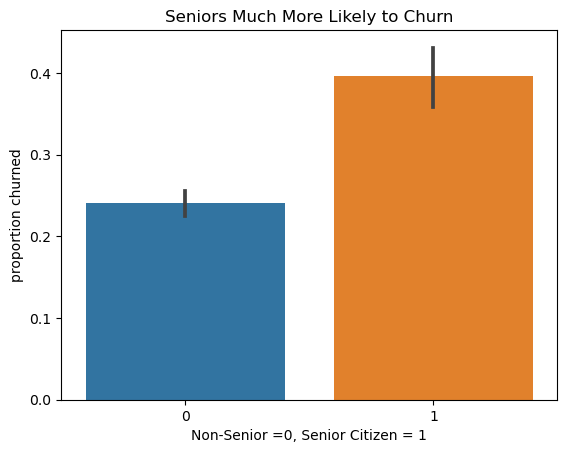

In [8]:
sns.barplot(x='senior_citizen', y='churn_encoded', data=train)
plt.title('Seniors Much More Likely to Churn')
plt.ylabel('proportion churned')
plt.xlabel('Non-Senior =0, Senior Citizen = 1')
plt.show()

##### Senior citizens churned at about 40% v 24% for non-seniors

#### Chi-Squared Test for relationship between being a senior and churn
Tests for relationship between at least 2 categories of one variable with at least 2 categories of another variable.

> $H_0$: There is no relationship between seniors and churn.

> $H_a$: There is a relationship between seniors and churn.

In [9]:
α = 0.05

observed_s = pd.crosstab(train.senior_citizen, train.churn_encoded)
observed_s

churn_encoded,0,1
senior_citizen,,
0,2516,796
1,381,250


In [10]:
chi2, p, degf, expected = stats.chi2_contingency(observed_s)
print(f'chi^2 = {chi2}\np = {p}\ndegrees of freedom = {degf}\nexpected values\n{pd.DataFrame(expected)}')


chi^2 = 65.26091692376309
p = 6.560972190703619e-16
degrees of freedom = 1
expected values
             0           1
0  2433.391834  878.608166
1   463.608166  167.391834


In [11]:
p < α

True

##### We must reject the $H_0$ that there is no relationship between seniors and churn

#### Conclusion: At the 95% confidence level there is a relationship between being a senior citizen and churn.

It seems like more than a coincindence that seniors are leaving in droves.
More research needs to be done to find out why this is the case.
___

### 2. Solo: Are solo customers leaving at a higher rate than expected for their proportion in the population?
- Solo customers are the group of customers with either no partner or no dependents.

In [12]:
train['solo_cust'] = (train.partner == 'No') & (train.dependents == 'No')

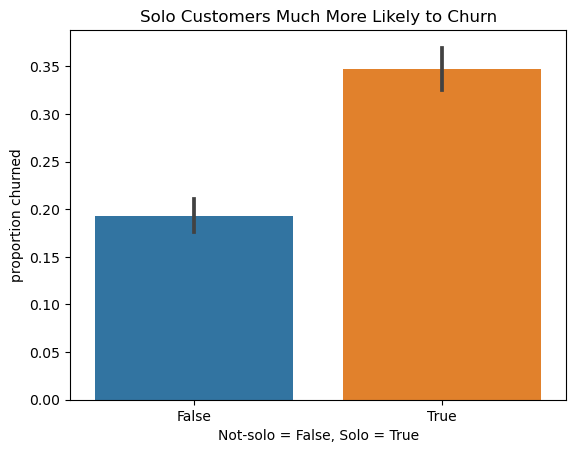

In [13]:
sns.barplot(x='solo_cust', y='churn_encoded', data=train)
plt.title('Solo Customers Much More Likely to Churn')
plt.ylabel('proportion churned')
plt.xlabel('Not-solo = False, Solo = True')
plt.show()

##### Solo customers churned at about 40% v 24% for those with dependents or partners

#### Chi-Squared Test for relationship between being solo and churn
Tests for relationship between at least 2 categories of one variable with at least 2 categories of another variable.

> $H_0$: There is no relationship between solo customers and churn.

> $H_a$: There is a relationship between solo customers and churn.

In [14]:
observed_solo = pd.crosstab(train.solo_cust, train.churn_encoded)
observed_solo

churn_encoded,0,1
solo_cust,,
False,1690,405
True,1207,641


In [15]:
chi2, p, degf, expected = stats.chi2_contingency(observed_solo)
print(f'chi^2 = {chi2}\np = {p}\ndegrees of freedom = {degf}\nexpected values\n{pd.DataFrame(expected)}')


chi^2 = 117.98128544103221
p = 1.750317195477364e-27
degrees of freedom = 1
expected values
            0          1
0  1539.23789  555.76211
1  1357.76211  490.23789


In [17]:
p < α

True

##### We must reject the $H_0$ that there is no relationship between solo customers and churn

#### Conclusion: At the 95% confidence level there is a relationship between being a solo customer and churn.

Solo customers naturally have more freedom to move around but maybe more could be done to appeal to them directly.
More research needs to be done to find out why this is the case.
___

### 3. Cost-to-Switch: Are customers without high cost-to-switch services leaving at a higher rate than expected for their proportion in the population?
- Cost-to-Switch services = Online Security and Online Backup

In [18]:
train['no_cost_to_switch'] = (
    train.online_security == 'No') & (train.online_backup == 'No')

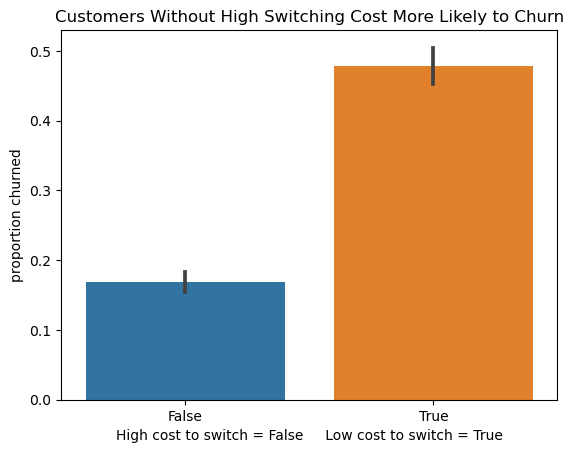

In [19]:
sns.barplot(x='no_cost_to_switch', y='churn_encoded', data=train)
plt.title('Customers Without High Switching Cost More Likely to Churn')
plt.ylabel('proportion churned')
plt.xlabel('High cost to switch = False     Low cost to switch = True')
plt.show()

- If it's easier for you to leave, it appears you are more likely to.

#### Chi-Squared Test for relationship between high switching cost services and churn
Tests for relationship between at least 2 categories of one variable with at least 2 categories of another variable.

> $H_0$: There is no relationship between customers without high switching costs and churn.

> $H_a$: There is a relationship between customers without high switching costs and churn.

In [20]:
observed_no_cost = pd.crosstab(train.no_cost_to_switch, train.churn_encoded)
observed_no_cost

churn_encoded,0,1
no_cost_to_switch,,
False,2255,459
True,642,587


In [21]:
chi2, p, degf, expected = stats.chi2_contingency(observed_no_cost)
print(f'chi^2 = {chi2}\np = {p}\ndegrees of freedom = {degf}\nexpected values\n{pd.DataFrame(expected)}')


chi^2 = 411.4866805491122
p = 1.7398656332759217e-91
degrees of freedom = 1
expected values
             0           1
0  1994.029419  719.970581
1   902.970581  326.029419


In [23]:
p < α

True

##### We must reject the $H_0$ that there is no relationship between customers without high cost to switch services and churn.

#### Conclusion: At the 95% confidence level there is a relationship between customers who don't subscribe to Online Security or Online Backup and churn.

- Low switching costs make it easier for customers to move around 
- Adding online backup or online security dramatically reduces churn.
___

### 4. Pain Point: Are customers with pain point services leaving at a higher rate than expected for their proportion in the population?
- Pain Point Services = Non-premium Tech Support, paying by e-check and Paperless Billing

In [24]:
train['pain_points'] = ((train.tech_support == 'No') | 
                        (train.paperless_billing == 'Yes') |
                        (train.payment_type == 'Electronic check'))

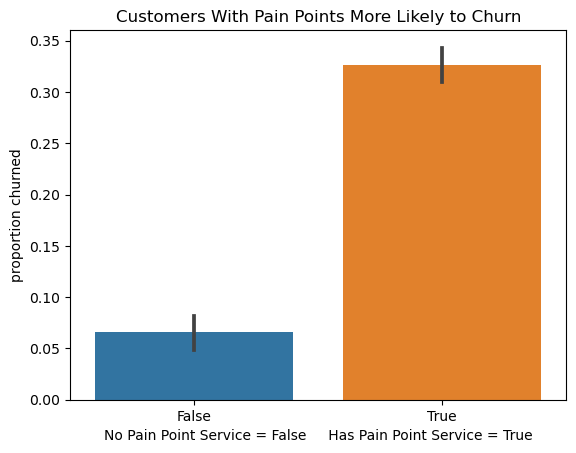

In [25]:
sns.barplot(x='pain_points', y='churn_encoded', data=train)
plt.title('Customers With Pain Points More Likely to Churn')
plt.ylabel('proportion churned')
plt.xlabel('No Pain Point Service = False     Has Pain Point Service = True')
plt.show()

- It seems Paperless Billing, regular tech support, and paying with Electronic Checks are driving people away.

#### Chi-Squared Test for relationship between pain point services and churn
Tests for relationship between at least 2 categories of one variable with at least 2 categories of another variable.

$H_0$: There is no relationship between customers with pain-point services and churn.

$H_a$: There is a relationship between customers with pain-point services and churn.

In [26]:
observed_pain = pd.crosstab(train.pain_points, train.churn_encoded)
observed_pain

churn_encoded,0,1
pain_points,,
False,862,61
True,2035,985


In [27]:
chi2, p, degf, expected = stats.chi2_contingency(observed_pain)
print(f'chi^2 = {chi2}\np = {p}\ndegrees of freedom = {degf}\nexpected values\n{pd.DataFrame(expected)}')


chi^2 = 243.98925273536645
p = 5.307616869625905e-55
degrees of freedom = 1
expected values
             0           1
0   678.146335  244.853665
1  2218.853665  801.146335


In [29]:
p < α

True

##### We must reject the $H_0$ that there is no relationship between customers with pain-point services and churn.

#### Conclusion: At the 95% confidence level there is a relationship between customers who use paperless billing, regular tech support, or electronic checks and churn.

- There certainly seem to be pain points with these services if customers using them are leaving at such high levels.
- Recommend exploring the user experience with these programs.
___

## Exploration Summary: What Reduces Churn
1. Contract type not monthly.
2. Not using Fiber Optic Internet.
3. Not being a senior.
4. Not being solo.
5. Using high cost-to-switch services.
6. Not using pain-point services.
7. Tenure over six months.


## Modeling

### Introduction

#### **Goal:** The goal of my modeling phase is to build a model that predicts customer churn. I think I have enough evidence for some specific recommendations based on bivariate stats, so I would like this model to use some engineered variables and the other significant drivers of churn to give the client tool to know which customers are likely to churn and maybe allow them to offer some just-in-time incentives to stay.

#### **Features:** the elements the model will use to make predictions
    1. contract_type_encoded
    2. internet_service_type_encoded
    3. senior_encoded
    4. solo_cust
    5. no_cost_to_switch
    6. pain_points
    7. tenure
    
#### **Evaluation**: Models will be evaluated in two ways
    1. against a baseline model using accuracy
        - accuracy measures total number of correct predictions over the total number of observations. It is a useful measure against the baseline model
    2. against each other using recall
        - recall measures the number of True Positive Predictions divided by total number of actual positive observations. I'm using it because I want to cast a wide net for customers who might churn. It can't be checked against baseline, but is the best measure for these models against each other.
        
#### The baseline model is created by replacing all predicted values with the most common class from the actual values. In this case that is '0' for did not churn.

In [30]:
# first I need to add the engineered features to val and test:
val['solo_cust'] = (val.partner == 'No') & (val.dependents == 'No')
val['no_cost_to_switch'] = (
    val.online_security == 'No') & (val.online_backup == 'No')
val['pain_points'] = ((val.tech_support == 'No') | 
                        (val.paperless_billing == 'Yes') |
                        (val.payment_type == 'Electronic check'))


In [31]:
test['solo_cust'] = (test.partner == 'No') & (test.dependents == 'No')
test['no_cost_to_switch'] = (
    test.online_security == 'No') & (test.online_backup == 'No')
test['pain_points'] = ((test.tech_support == 'No') | 
                        (test.paperless_billing == 'Yes') |
                        (test.payment_type == 'Electronic check'))

In [32]:
# Adding the baseline to each data set
train.churn_encoded.value_counts(normalize=True)
train['baseline_prediction'] = 0
val['baseline_prediction'] = 0
test['baseline_prediction'] = 0

# create X & y version of train, where y is a series 
# with just the target variable and X are all the features. 
features = ['contract_type_One year','contract_type_Two year',
            'internet_service_type_Fiber optic', 'internet_service_type_None', 
            'senior_citizen', 'solo_cust', 'no_cost_to_switch', 'pain_points', 'tenure']
X_train = train[features]
y_train = train.churn_encoded

X_val = val[features]
y_val = val.churn_encoded

X_test = test[features]
y_test = test.churn_encoded

print('Baseline Accuracy = .73')
print(classification_report(y_train, train['baseline_prediction']))

Baseline Accuracy = .73
              precision    recall  f1-score   support

           0       0.73      1.00      0.85      2897
           1       0.00      0.00      0.00      1046

    accuracy                           0.73      3943
   macro avg       0.37      0.50      0.42      3943
weighted avg       0.54      0.73      0.62      3943



##### The baseline accuracy = .73

### Best 3 Models
* Show the three best model results obtained using your selected features to predict the target variable
* Typically students will show the top models they are able to generate for three different model types

### Random Forest Model # 1

In [33]:
# make the thing

rf1 = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=10, 
                            random_state=9751)


# fit the thing
rf1.fit(X_train, y_train)

# use the thing
rf1_preds = rf1.predict(X_train)

print(f'''
Performance in accuracy of Random Forest 1 on training data:
Accuracy (train): {rf1.score(X_train, y_train)}
Accuracy (validate): {round(rf1.score(X_val, y_val), 2)}''')
print('________________________________________________')
print('________________________________________________')
# classification report:
print(
    classification_report(y_train,
                      rf1_preds))



Performance in accuracy of Random Forest 1 on training data:
Accuracy (train): 0.8227238143545523
Accuracy (validate): 0.79
________________________________________________
________________________________________________
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      2897
           1       0.69      0.60      0.64      1046

    accuracy                           0.82      3943
   macro avg       0.78      0.75      0.76      3943
weighted avg       0.82      0.82      0.82      3943



#### Random Forest Model 1 has a high accuracy score, but this falls off a little bit when tested on the validate set. The recall score of .60 is good, but I worry that the model is overfit.

### Random Forest Model # 6

In [34]:
rf6 = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=2,
                            n_estimators=100,
                            max_depth=8, 
                            random_state=9751)
rf6.fit(X_train, y_train)
rf6_preds = rf6.predict(X_train)
print(f'''
Performance in accuracy of Random Forest 6 on training data:
Accuracy (train): {rf6.score(X_train, y_train)}
Accuracy (validate): {round(rf6.score(X_val, y_val), 2)}''')
print('________________________________________________')
print('________________________________________________')
# classification report:
print(
    classification_report(y_train,
                      rf6_preds))


Performance in accuracy of Random Forest 6 on training data:
Accuracy (train): 0.8082678163834643
Accuracy (validate): 0.8
________________________________________________
________________________________________________
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      2897
           1       0.67      0.54      0.60      1046

    accuracy                           0.81      3943
   macro avg       0.76      0.72      0.74      3943
weighted avg       0.80      0.81      0.80      3943



#### Random Forest Model 6 has a high accuracy score, but still falls off slightly when tested on the validate set. The recall score of .54 is ok.

### Decision Tree Model # 4

In [35]:
clf4 = DecisionTreeClassifier(max_depth=5, min_samples_leaf=5)

clf4.fit(X_train, y_train)
clf4_preds = clf4.predict(X_train)
print(f'''
Performance in accuracy of Decision Tree 4 on training data:
Accuracy (train): {clf4.score(X_train, y_train)}
Accuracy (validate): {round(clf4.score(X_val, y_val), 2)}''')
print('________________________________________________')
print('________________________________________________')
# classification report:
print(
    classification_report(y_train,
                      clf4_preds))


Performance in accuracy of Decision Tree 4 on training data:
Accuracy (train): 0.7968551864062896
Accuracy (validate): 0.8
________________________________________________
________________________________________________
              precision    recall  f1-score   support

           0       0.84      0.89      0.87      2897
           1       0.64      0.53      0.58      1046

    accuracy                           0.80      3943
   macro avg       0.74      0.71      0.72      3943
weighted avg       0.79      0.80      0.79      3943



#### Decision Tree Model # 4 has a decent accuracy score, and actually improves slightly when tested on the validate set. The recall score of .53 is ok.

### Test Model
* I chose Decision Tree Model # 3 as my test model as it actually performed better against the validate set and both of the other models performed worse.

* Now I will run this model on the Test dataset that was reserved as part of the splitting process to simulate performace of the churn predictions 'in the wild'

In [38]:
# Code that ru# final test: on the test
# remember! just once! not just once per algorithm!
# use the assessment on your test set *AFTER* you have chosen your best model
print(f'Accuracy of clf4 model on Test data set: {clf4.score(X_test, y_test)}')

Accuracy of clf4 model on Test data set: 0.794180269694819


In [39]:
# classification report:
y_pred = clf4.predict(X_test)
print(classification_report(y_test,
                      y_pred))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1035
           1       0.65      0.48      0.56       374

    accuracy                           0.79      1409
   macro avg       0.74      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409



### Modeling Wrap 
* The model accuracy was pretty consistent with the validation set, however the recall declined slightly to .48. This is still almost double the rate of picking a customer at random.

In [41]:
test.churn_encoded.value_counts(normalize=True)

0    0.734564
1    0.265436
Name: churn_encoded, dtype: float64

## Conclusion

### Summary
* Senior status, Solo Customers, Leaving Cost, and Pain Points all proved to have significant relationships to churn 
* The drivers used in the model were successful at creating a model that performed above baseline at predicting customer churn. 

### Recommendations
1. Incentivize Tenures in the first six months.
2. Increase number of contracted customers.
3. Understand why users with Fiber Optic Internet are leaving.
4. Understand why seniors are leaving.
5. Court solo customers.
6. Incentivize high cost-to-switch services.
7. Explore and fix pain-point services.


### Next Steps
1. Break features apart in the model and see how that changes predictions
2. Explore other algorithms for modeling